# Setup

## Imports

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Parameters

In [4]:
keys = [
    'Bacon2019',
    'hafenLowredshiftLymanLimit2017',
    'Imeletal2022',
    'Ololube2012',
    'Torres2013',
    'West2003',
]
key = keys[1]
librarian = 'S2'
vectorizer = 'SciBERT'

## Process Parameters

In [5]:
directory = os.path.join(
    '../../outputs',
    f'librarian={librarian}',
    f'vectorizer={vectorizer}',
)

# Data Preprocessing

In [6]:
dfs = []
for key in keys:
    fp = os.path.join(directory, f'center={key}/all_data.csv')
    df = pd.read_csv(fp)

    # Density categorization
    med_density = df['density'].median()
    df['density_cat'] = (df['density'] > med_density).astype('category')
    df['density_cat'] = df['density_cat'].cat.rename_categories(
        {True: 'Upper', False: 'Lower'})

    # Center category
    df['center'] = key

    dfs.append(df)

In [7]:
# Combine
df = pd.concat(dfs)

In [8]:
# Make a combined category
df['label'] = (
    df['center'].astype(str) + '_' + df['density_cat'].astype(str)
).astype('category')

In [9]:
# Make a log scale version
df['log_cpy'] = np.log10(df['citations_per_year'])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

/Users/Shared/miniconda3/envs/llm/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Visualization

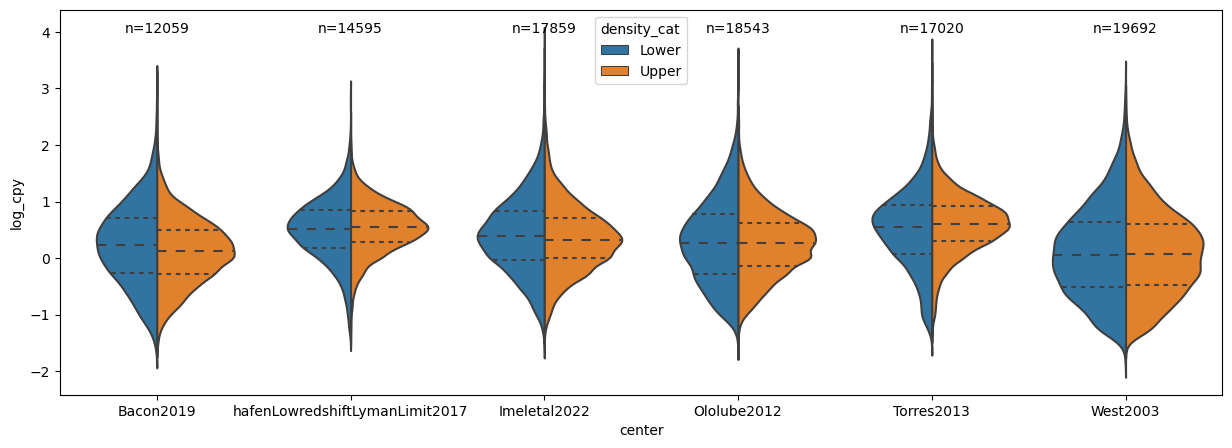

In [67]:
import matplotlib.transforms


fig = plt.figure(figsize=(len(keys) * 2.5, 5))
ax = plt.gca()

sns.violinplot(
    ax=ax,
    data=df,
    x='center',
    y='log_cpy',
    hue='density_cat',
    split=True,
    inner='quart',
    dodge=True,
    gap=0,
)

for i, key in enumerate(keys):
    df_key = df[df['center'] == key]
    n = df_key.shape[0]
    ax.annotate(
        text=f'n={n}',
        xy=(i, 0.95),
        ha='center',
        va='center',
        xycoords=matplotlib.transforms.blended_transform_factory(
            ax.transData,
            ax.transAxes,
        )
    )

legend = ax.get_legend()
legend.set_loc('upper center')
legend.set_bbox_to_anchor((0.5, 1.0))
legend.set_alignment('left')